In [1]:
# Adapted from https://github.com/pytorch/vision/blob/v0.4.0/torchvision/models/resnet.py
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.data import AUTOTUNE

img_height = 256
img_width = 256
image_dir = "images"
batch_size = 32

2023-03-01 15:23:23.317566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    labels="inferred",
    class_names=["Austria","Australia"],
    subset="both",
    seed = 0,
    batch_size = batch_size,
    crop_to_aspect_ratio=True,
    image_size=(img_height, img_width))


Found 25064 files belonging to 2 classes.
Using 20052 files for training.
Using 5012 files for validation.


In [3]:
model = keras.Sequential(
    [
    layers.Conv2D(32, (3,3), input_shape = (img_height,img_width,3), activation = "relu", padding="same"),
    layers.MaxPooling2D((2,2), padding="same"),
    layers.Conv2D(32, (3,3), activation = "relu", padding="same"),
    layers.MaxPooling2D((2,2), padding="same"),
    layers.Conv2D(32, (3,3), activation = "relu", padding="same"),
    layers.MaxPooling2D((2,2), padding="same"),
    layers.Conv2D(32, (3,3), activation = "relu", padding="same"),
    layers.MaxPooling2D((2,2), padding="same"),
    layers.Conv2D(32, (3,3), activation = "relu", padding="same"),
    layers.MaxPooling2D((2,2), padding="same"),
    layers.Conv2D(32, (3,3), activation = "relu", padding="same"),
    layers.MaxPooling2D((2,2), padding="same"),
    layers.Flatten(),
    layers.Dense(100),
    layers.Dropout(0.1),
    layers.Dense(1, activation = 'sigmoid'),
    ])

optimizer = optimizers.Adam(learning_rate = 0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics = ["accuracy"])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0

In [5]:
def standardize_image(image, label):
    mean = tf.reduce_mean(image)
    std = tf.math.reduce_std(image)
    standardized_image = tf.map_fn(lambda x: (x - mean)/std, image)
    return (standardized_image, label)

train_ds =  train_ds.map(standardize_image)
val_ds = val_ds.map(standardize_image)


train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)


In [6]:
history = model.fit(train_ds, epochs = 20, validation_data = val_ds)

Epoch 1/20
627/627 [==============================] - 510s 811ms/step - loss: 0.3680 - accuracy: 0.8300 - val_loss: 0.3272 - val_accuracy: 0.8733
Epoch 2/20
627/627 [==============================] - 504s 803ms/step - loss: 0.2524 - accuracy: 0.8956 - val_loss: 0.2311 - val_accuracy: 0.9044
Epoch 3/20
627/627 [==============================] - 503s 800ms/step - loss: 0.2093 - accuracy: 0.9158 - val_loss: 0.1807 - val_accuracy: 0.9278
Epoch 4/20
627/627 [==============================] - 511s 814ms/step - loss: 0.1740 - accuracy: 0.9301 - val_loss: 0.1580 - val_accuracy: 0.9385
Epoch 5/20
627/627 [==============================] - 501s 798ms/step - loss: 0.1499 - accuracy: 0.9412 - val_loss: 0.2128 - val_accuracy: 0.9226
Epoch 6/20
627/627 [==============================] - 504s 791ms/step - loss: 0.1332 - accuracy: 0.9491 - val_loss: 0.1784 - val_accuracy: 0.9356
Epoch 7/20
627/627 [==============================] - 516s 821ms/step - loss: 0.1185 - accuracy: 0.9544 - val_loss: 0.1699 -

In [7]:
model.save('neural_net')

INFO:tensorflow:Assets written to: neural_net/assets


INFO:tensorflow:Assets written to: neural_net/assets


In [8]:
# Sanity checking the val_accuracy
loss, accuracy = model.evaluate(val_ds)
print(loss, accuracy)

predictions = model.predict(val_ds).reshape((5012,))
labels = np.array([x for x in val_ds.unbatch().map(lambda x,y: y)])

157/157 [==============================] - 34s 214ms/step - loss: 0.2253 - accuracy: 0.9370
0.22534610331058502 0.9369513392448425
157/157 [==============================] - 34s 216ms/step


In [9]:
confidence = 1 - np.abs(predictions - np.round(predictions))
print(f"Average confidence: {100*np.mean(confidence):.2f}%")
print(f"Average confidence (correct labels): {100*np.mean(confidence[np.round(predictions) == labels]):.2f}%")
print(f"Average confidence (wrong labels): {100*np.mean(confidence[np.round(predictions) != labels]):.2f}%")


Average confidence: 97.32%
Average confidence (correct labels): 98.19%
Average confidence (wrong labels): 84.40%


1/1 [==============================] - 0s 205ms/step


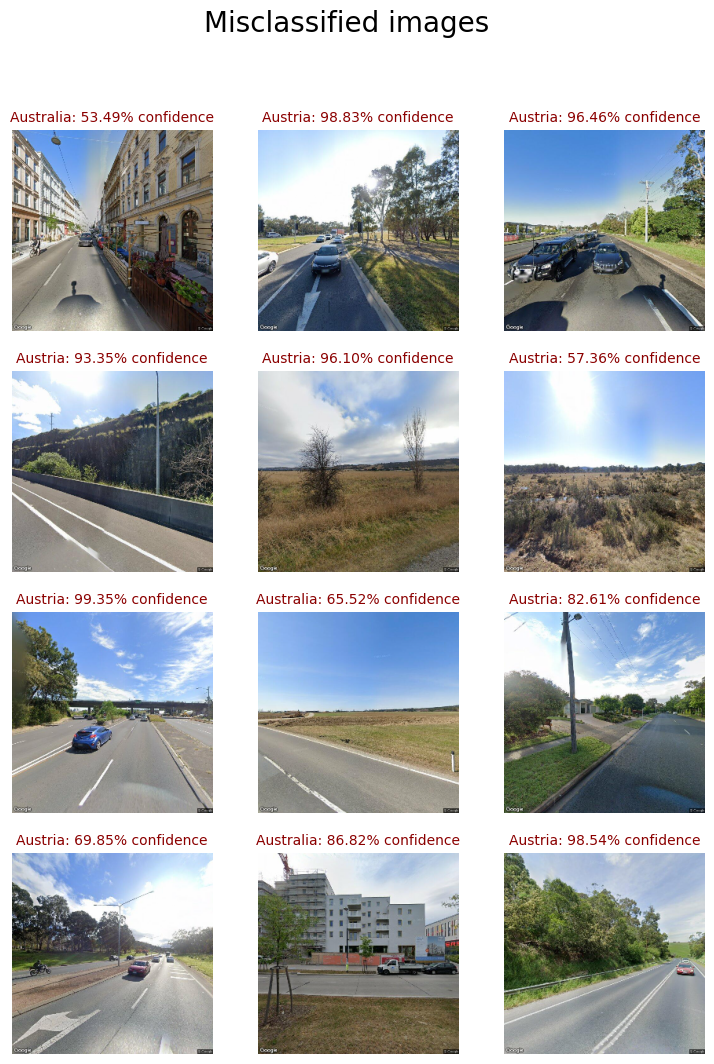

In [10]:
def plot_standardized_image(image):
    image = image.numpy()
    image_min = np.min(image)
    image_max = np.max(image)
    if image_max - image_min > 0:
        image = (image - (image_min + image_max)/2)/(image_max - image_min) + 1/2
    plt.imshow(image)


num_images = 12
    
fig = plt.figure(figsize=(9, num_images))
plt.suptitle("Misclassified images", size = 20)
class_names = ["Austria", "Australia"]
val_ds.shuffle(buffer_size = 1000)
i = 1
for images, labels in val_ds.take(10):
    predictions = model.predict(images).reshape((32,))
    hard_predictions = np.round(predictions)
    actual_labels = labels.numpy()
    prediction_results = (hard_predictions == actual_labels)
    for image, prediction, predicted_label, actual_label in zip(images, predictions, hard_predictions, actual_labels):
        if predicted_label != actual_label:
            ax = plt.subplot(num_images//3, 3, i)
            plot_standardized_image(image)
            if prediction > 0.5:
                plt.title(f"Australia: {100*prediction:.2f}% confidence", color = "darkred", size = 10)
            else:
                plt.title(f"Austria: {100*(1-prediction):.2f}% confidence", color = "darkred", size = 10)
            plt.axis("off")
            i += 1
        if i > num_images:
            break
    if i > num_images:
        break
plt.show()       


1/1 [==============================] - 0s 401ms/step


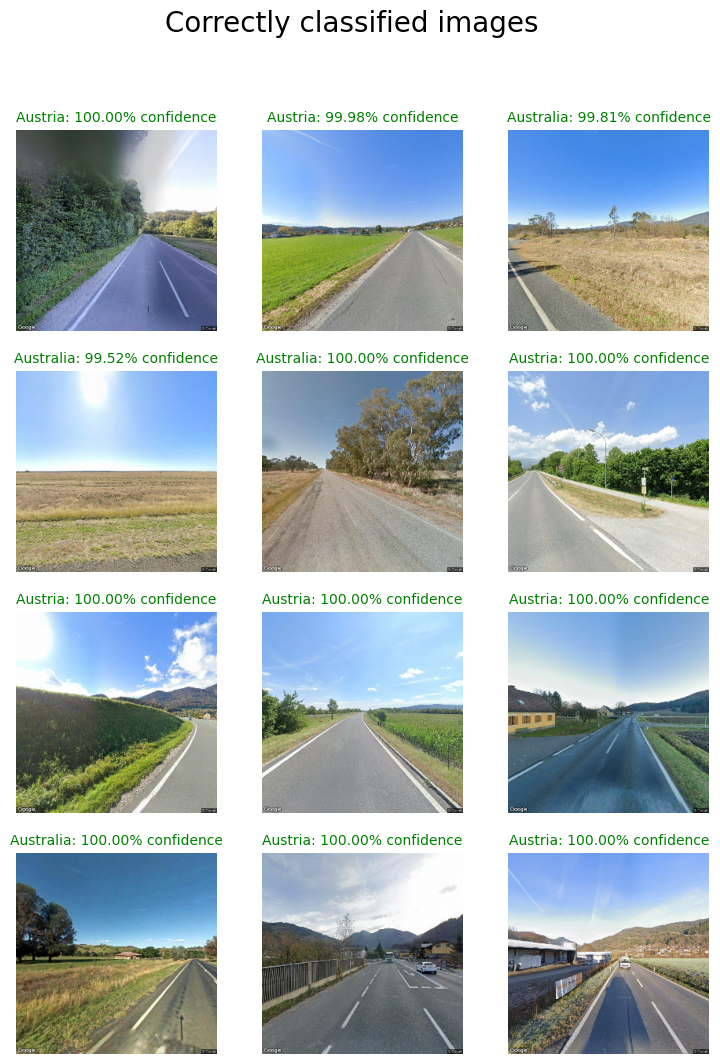

In [12]:
num_images = 12
    
fig = plt.figure(figsize=(9, num_images))
plt.suptitle("Correctly classified images", size = 20)
class_names = ["Austria", "Australia"]
val_ds.shuffle(buffer_size = 1000)
i = 1
for images, labels in val_ds.take(10):
    predictions = model.predict(images).reshape((32,))
    hard_predictions = np.round(predictions)
    actual_labels = labels.numpy()
    prediction_results = (hard_predictions == actual_labels)
    for image, prediction, predicted_label, actual_label in zip(images, predictions, hard_predictions, actual_labels):
        if predicted_label == actual_label:
            ax = plt.subplot(num_images//3, 3, i)
            plot_standardized_image(image)
            if prediction > 0.5:
                plt.title(f"Australia: {100*prediction:.2f}% confidence", color = "green", size = 10)
            else:
                plt.title(f"Austria: {100*(1-prediction):.2f}% confidence", color = "green", size = 10)
            plt.axis("off")
            i += 1
        if i > num_images:
            break
    if i > num_images:
        break
plt.show()      

1/1 [==============================] - 0s 191ms/step


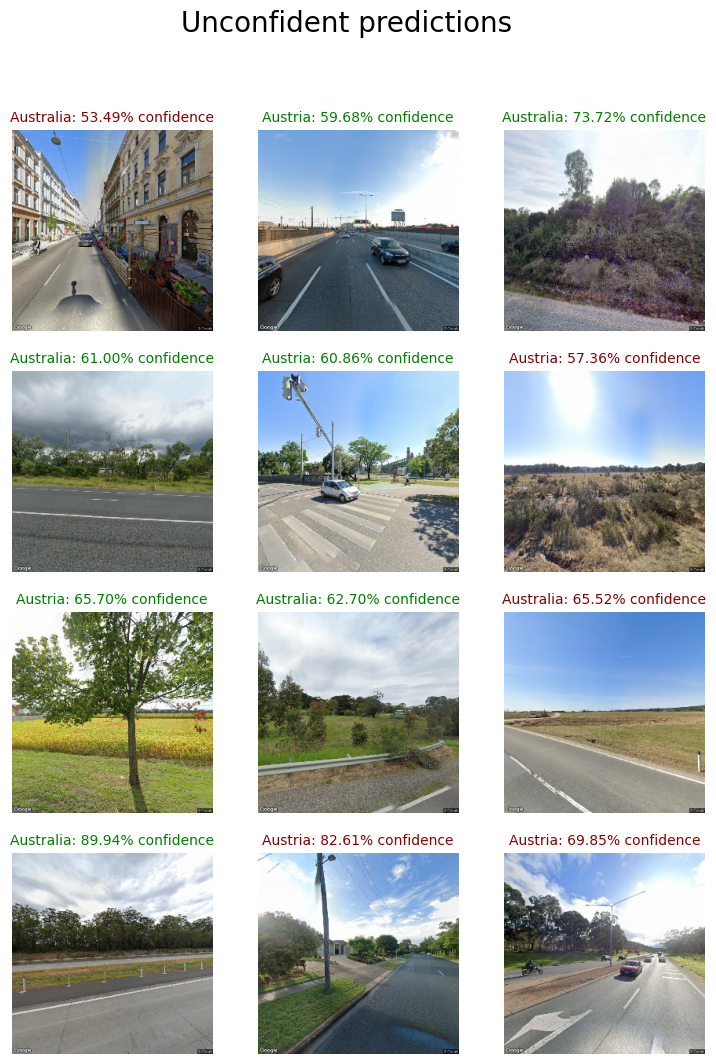

In [13]:
num_images = 12
    
fig = plt.figure(figsize=(9, num_images))
plt.suptitle("Unconfident predictions", size = 20)
class_names = ["Austria", "Australia"]
val_ds.shuffle(buffer_size = 1000)
i = 1
for images, labels in val_ds.take(30):
    predictions = model.predict(images).reshape((32,))
    hard_predictions = np.round(predictions)
    actual_labels = labels.numpy()
    for image, prediction, label in zip(images, predictions, actual_labels):
        if prediction > 0.5 and prediction < 0.9:
            ax = plt.subplot(num_images//3, 3, i)
            plot_standardized_image(image)
            if round(prediction) == label:
                plt.title(f"Australia: {100*prediction:.2f}% confidence", size = 10, color = "green")
            else:
                plt.title(f"Australia: {100*prediction:.2f}% confidence", size = 10, color = "darkred")
            plt.axis("off")
            i += 1
        elif prediction <= 0.5 and prediction > 0.1:
            ax = plt.subplot(num_images//3, 3, i)
            plot_standardized_image(image)
            
            if round(prediction) == label:
                plt.title(f"Austria: {100*(1-prediction):.2f}% confidence", size = 10, color = "green")
            else:
                plt.title(f"Austria: {100*(1-prediction):.2f}% confidence", size = 10, color = "darkred")
            plt.axis("off")
            i += 1
        if i > num_images:
            break
    if i > num_images:
        break
plt.show()      

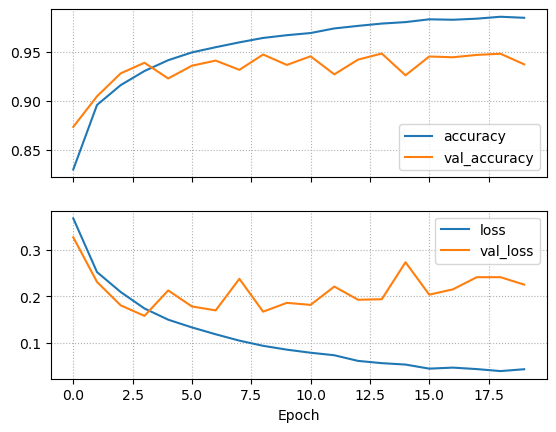

In [14]:
fig, axs = plt.subplots(2,1, sharex = True)
keys = [["accuracy", "val_accuracy"], ["loss", "val_loss"]]
for (ax, k) in zip(axs,keys):
    for key in k:
        ax.plot(history.history[key], label = key)
    
    ax.legend()
    ax.grid(linestyle = "dotted")

plt.xlabel("Epoch")
plt.show()